In [132]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from torch import nn

from nlp_assemblee.simple_trainer import LitModel, load_embedding

RESULT_DIR = Path("../../results/topic_modelling/")

In [ ]:
model_name = "dangvantuan/sentence-camembert-base"
encoder = SentenceTransformer(model_name, device="cuda")
encoder.eval()

In [6]:
df = pd.read_pickle("../../data/processed/15th_merged_data_short.pkl")
df = df[
    [
        "nom",
        "groupe",
        "date_seance",
        "nb_mots_approx",
        "profession",
        "titre",
        "titre_complet",
        "intervention",
        "sexe",
        "n_y_naissance",
        "label",
    ]
]
reg = "(article|l'article)\s*(\d+[^\w\s]*|premier|deuxième|troisième|[^\w\s]*\d+[^\w\s]*)"
df["titre_regexed"] = df["titre"].str.replace(reg, "Article X", regex=True)
df["contexte"] = (
    df["titre_complet"].str.split(" > ").apply(lambda x: x[0] if len(x) > 1 else "Sans contexte")
)

In [5]:
# embeddings = model.encode(df["intervention"].tolist(), batch_size=128,
# show_progress_bar=True, device="cuda")

# with open("../../data/precomputed/topic_modelling_embeddings.pkl", "wb") as f:
#     pickle.dump(embeddings, f)

In [8]:
deputes = ["Jean-Luc Mélenchon", "Marine Le Pen"]
groupes = ["LFI", "LR", "NI"]

idx = df[(df.groupe.isin(groupes)) & (df.nb_mots_approx < 64) & (df.nb_mots_approx > 16)].index
len(idx)

23402

In [9]:
docs = df.loc[idx, "intervention"].tolist()
labels = df.loc[idx, "label"].tolist()
sexes = df.loc[idx, "sexe"].map({"H": 0.0, "F": 1.0}).tolist()
naissance = df.loc[idx, "n_y_naissance"].tolist()
titre = encoder.encode(
    df.loc[idx, "titre_regexed"].tolist(), batch_size=128, show_progress_bar=True, device="cuda"
)
contexte = encoder.encode(
    df.loc[idx, "contexte"].tolist(), batch_size=128, show_progress_bar=True, device="cuda"
)
embs = encoder.encode(
    df.loc[idx, "intervention"].tolist(), batch_size=128, show_progress_bar=True, device="cuda"
)

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

In [10]:
topic_model = BERTopic(
    embedding_model=encoder, top_n_words=10, calculate_probabilities=True, verbose=True
)
topics, probs = topic_model.fit_transform(docs, embeddings=embs)

2023-02-18 18:36:48,800 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-02-18 18:37:02,396 - BERTopic - Clustered reduced embeddings


## Analyse

In [133]:
freq = topic_model.get_topic_info()
freq.head(25)

Topic  Count                                               Name
0      -1  16283                                   -1_de_la_vous_le
1       0    742                             0_impôt_csg_taxe_euros
2       1    413                1_territoires_vise_mobilité_conseil
3       2    374                  2_motion_renvoi_amendements_rejet
4       3    203                             3_délai_mois_jours_six
5       4    202                          4_amendement_retire_no_je
6       5    198           5_référendum_peuple_démocratie_assemblée
7       6    154                    6_euros_déficit_milliards_dette
8       7    152              7_nucléaire_énergies_énergie_fossiles
9       8    151                 8_médecins_médecine_soins_hôpitaux
10      9    145                    9_enfant_filiation_père_enfants
11     10    137                10_indicateurs_prix_amendement_vise
12     11    130                11_europe_européenne_union_européen
13     12    125             12_logement_logements_pinel_construire
14     13    118               13_suspension_séance_minutes_demande
15     14    116                14_madame_présidente_monsieur_chers
16     15    115                                15_propos_je_pas_ne
17     16    112                      16_règlement_58_rappel_alinéa
18     17    107                 17_asile_demandes_nationalité_pays
19     18     96  18_formation_apprentissage_entreprise_professi...
20     19     94                   19_jaunes_gilets_mouvement_gilet
21     20     89               20_budget_budgétaire_comptes_crédits
22     21     81     21_université_étudiants_enseignement_sélection
23     22     78                  22_euros_milliards_millions_fonds
24     23     74                  23_benalla_élysée_alexandre_badge

In [140]:
emb_fig = topic_model.visualize_documents(docs, embeddings=embs)
emb_fig.show(renderer="svg")

In [137]:
emb_fig.write_html(RESULT_DIR / "topic_modelling_embeddings.html", include_plotlyjs="cdn")
emb_fig.write_image(RESULT_DIR / "topic_modelling_embeddings.png")

In [ ]:
# .update_topics(docs, n_gram_range=(1, 3))
# .reduce_topics(docs, nr_topics=30)
# .find_topics("vehicle")

In [14]:
topic_df = topic_model.get_document_info(docs)
topic_df[topic_df["Topic"] != -1].head(20)

Document  Topic  \
2   Un peu de précision dans les termes nous aider...      5   
4   Si vous voulez moraliser la vie politique du p...      0   
6   …bref, limitez de toutes les façons possibles ...      5   
8   Mais enfin, qu'est-ce qui leur prend ? Il disp...     13   
9   Vous ne devriez pas permettre de tels propos, ...     15   
18  Je m'oppose à cet amendement ; vos arguments o...    118   
19  Pardon de vous le dire, madame : vous aussi !À...     89   
20  Voici de quoi nous vous parlons : de rien d'au...     89   
26  C'est bon ! Vous avez les nerfs à fleur de pea...    139   
28  …puisqu'il vise à supprimer l'alinéa 4, comme ...     30   
32  J'aimerais répondre à mes collègues – sans fai...     15   
35  Madame la présidente, on n'y comprend plus rie...     13   
36  Voilà ce qui apparaîtra politiquement ! Nous e...     24   
47  Non, nos débats ne se déroulent pas calmement ...     15   
49  C'est pourquoi nous vous avons proposé le réfé...      5   
58  Le gouvernement espagnol s'est enfoncé, d'un s...     11   
62  J'ajoute que je partage le diagnostic du Prési...     11   
65  Pour conclure, si j'ai moi aussi, bien sûr, le...     11   
68  Merci, mes chers collègues.Monsieur Castaner, ...     50   
73  Mais c'est de cela dont nous parlons, mesdames...      0   

                                        Name  \
2   5_référendum_peuple_démocratie_assemblée   
4                     0_impôt_csg_taxe_euros   
6   5_référendum_peuple_démocratie_assemblée   
8       13_suspension_séance_minutes_demande   
9                        15_propos_je_pas_ne   
18    118_défendrai_permettez_no_amendements   
19   89_télétravail_travail_entreprises_vise   
20   89_télétravail_travail_entreprises_vise   
26             139_rire_subtils_rigoler_riez   
28       30_alinéa_article_alinéas_supprimer   
32                       15_propos_je_pas_ne   
35      13_suspension_séance_minutes_demande   
36           24_débat_nous_débats_discussion   
47                       15_propos_je_pas_ne   
49  5_référendum_peuple_démocratie_assemblée   
58       11_europe_européenne_union_européen   
62       11_europe_européenne_union_européen   
65       11_europe_européenne_union_européen   
68       50_hommage_victimes_rendre_attentat   
73                    0_impôt_csg_taxe_euros   

                                          Top_n_words  Probability  \
2   référendum - peuple - démocratie - assemblée -...     0.043542   
4   impôt - csg - taxe - euros - sur - retraités -...     0.134340   
6   référendum - peuple - démocratie - assemblée -...     0.012032   
8   suspension - séance - minutes - demande - temp...     0.038003   
9   propos - je - pas - ne - vous - arguments - ai...     0.109182   
18  défendrai - permettez - no - amendements - tem...     0.092723   
19  télétravail - travail - entreprises - vise - r...     1.000000   
20  télétravail - travail - entreprises - vise - r...     0.513852   
26  rire - subtils - rigoler - riez - intelligents...     1.000000   
28  alinéa - article - alinéas - supprimer - amend...     0.036240   
32  propos - je - pas - ne - vous - arguments - ai...     0.122291   
35  suspension - séance - minutes - demande - temp...     0.305157   
36  débat - nous - débats - discussion - feux - se...     0.075998   
47  propos - je - pas - ne - vous - arguments - ai...     0.083875   
49  référendum - peuple - démocratie - assemblée -...     0.050715   
58  europe - européenne - union - européen - défen...     0.073005   
62  europe - européenne - union - européen - défen...     0.251033   
65  europe - européenne - union - européen - défen...     1.000000   
68  hommage - victimes - rendre - attentat - polic...     0.156748   
73  impôt - csg - taxe - euros - sur - retraités -...     0.060018   

    Representative_document  
2                     False  
4                     False  
6                     False  
8                     False  
9                     False  
18                    False  
19        

In [121]:
df.head()

nom groupe date_seance  nb_mots_approx  profession  \
0  Jean-Luc Mélenchon    LFI  2017-06-28             210  Professeur   
1  Jean-Luc Mélenchon    LFI  2017-06-28              64  Professeur   
2  Jean-Luc Mélenchon    LFI  2017-06-28              50  Professeur   
3  Jean-Luc Mélenchon    LFI  2017-06-28              58  Professeur   
4  Jean-Luc Mélenchon    LFI  2017-06-28              45  Professeur   

                                               titre  \
0  Élection des six vice-présidents et des trois ...   
1  Élection des six vice-présidents et des trois ...   
2  Élection des six vice-présidents et des trois ...   
3  Élection des six vice-présidents et des trois ...   
4  Élection des six vice-présidents et des trois ...   

                                       titre_complet  \
0  Élection des six vice-présidents et des trois ...   
1  Élection des six vice-présidents et des trois ...   
2  Élection des six vice-présidents et des trois ...   
3  Élection des six vice-présidents et des trois ...   
4  Élection des six vice-présidents et des trois ...   

                                        intervention sexe  n_y_naissance  \
0  Monsieur le président, sans vouloir compliquer...    H       0.865854   
1  Merci, monsieur le président. Une situation no...    H       0.865854   
2  Nous les avons décidés dans le passé – je m'y ...    H       0.865854   
3  à savoir être tous représentés par un vice-pré...    H       0.865854   
4  Un peu de précision dans les termes nous aider...    H       0.865854   

   label                                      titre_regexed       contexte  
0    0.0  Élection des six vice-présidents et des trois ...  Sans contexte  
1    0.0  Élection des six vice-présidents et des trois ...  Sans contexte  
2    0.0  Élection des six vice-présidents et des trois ...  Sans contexte  
3    0.0  Élection des six vice-présidents et des trois ...  Sans contexte  
4    0.0  Élection des six vice-présidents et des trois ...  Sans contexte

In [122]:
analysis_df = pd.concat([topic_df, df.loc[idx].reset_index()], axis=1)
analysis_df = analysis_df[(analysis_df["Topic"] != -1)]

## Use trained model

In [70]:
experiment = "ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001"
CKPT_PATH = Path(f"../../results/new_features/{experiment}/lightning_logs/")

In [71]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class AttentionUnit(nn.Module):
    def __init__(self, in_dim, out_dim, n_heads=4, dropout=0.2):
        super().__init__()
        self.query_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.key_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.value_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.attn_head = nn.MultiheadAttention(out_dim, n_heads, batch_first=True, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm((3, out_dim))
        self.feed_forward = LinearUnit(out_dim, out_dim, dropout=dropout)
        self.layer_norm2 = nn.LayerNorm((3, out_dim))

    def forward(self, x):
        query = self.query_linear(x)
        key = self.key_linear(x)
        value = self.value_linear(x)
        attn_repr, _ = self.attn_head(query, key, value, need_weights=False)
        attn_repr_summed = x + attn_repr
        normed_repr = self.layer_norm1(attn_repr_summed)
        feed_repr = self.feed_forward(normed_repr)
        feed_repr_summed = normed_repr + feed_repr
        normed_repr2 = self.layer_norm2(feed_repr_summed)
        return normed_repr2


class Net(nn.Module):
    def __init__(
        self,
        root,
        input_dim,
        hidden_dim,
        feature_dim,
        n_heads=4,
        n_attn_layer=1,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, input_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            },
            "features": torch.randn(32, 2),
        }

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.n_attn_layer = n_attn_layer

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = LinearUnit(input_dim, hidden_dim, dropout=dropout)

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = LinearUnit(input_dim, hidden_dim, dropout=dropout)

        self.features_fc = nn.Sequential(
            LinearUnit(2, feature_dim // 2, dropout=dropout),
            LinearUnit(feature_dim // 2, feature_dim, dropout=dropout),
        )

        self.intervention_fc = LinearUnit(input_dim, hidden_dim, dropout=dropout)

        attn_layers = [
            AttentionUnit(hidden_dim, hidden_dim, n_heads, dropout=dropout)
            for i in range(n_attn_layer)
        ]
        self.attn_heads = nn.Sequential(*attn_layers)

        self.mlp = nn.Sequential(
            LinearUnit(hidden_dim + feature_dim, hidden_dim),
            LinearUnit(hidden_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]
        features = x["features"].float()

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        if self.noise > 0:
            titre_emb = titre_emb + torch.randn_like(titre_emb) * self.noise
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        if self.noise > 0:
            contexte_emb = contexte_emb + torch.randn_like(contexte_emb) * self.noise
        contexte_repr = self.contexte_fc(contexte_emb)

        features_repr = self.features_fc(features)

        pooled_repr = torch.cat(
            [intervention_repr.unsqueeze(1), titre_repr.unsqueeze(1), contexte_repr.unsqueeze(1)],
            dim=1,
        )

        attn_repr = self.attn_heads(pooled_repr)

        final_repr = torch.cat([attn_repr[:, 0, :].squeeze(1), features_repr], dim=1)

        logits = self.mlp(final_repr)

        return logits

    def forward_without_embeddings(self, **x):
        intervention = x["text"]["intervention"]
        titre_emb = x["text"]["titre_regexed"]
        contexte_emb = x["text"]["contexte"]
        features = x["features"].float()
        intervention_repr = self.intervention_fc(intervention)
        if self.noise > 0:
            titre_emb = titre_emb + torch.randn_like(titre_emb) * self.noise
        titre_repr = self.titre_fc(titre_emb)
        if self.noise > 0:
            contexte_emb = contexte_emb + torch.randn_like(contexte_emb) * self.noise
        contexte_repr = self.contexte_fc(contexte_emb)

        features_repr = self.features_fc(features)
        pooled_repr = torch.cat(
            [intervention_repr.unsqueeze(1), titre_repr.unsqueeze(1), contexte_repr.unsqueeze(1)],
            dim=1,
        )
        attn_repr = self.attn_heads(pooled_repr)
        final_repr = torch.cat([attn_repr[:, 0, :].squeeze(1), features_repr], dim=1)
        logits = self.mlp(final_repr)
        probs = torch.softmax(logits, dim=1)

        return probs

In [72]:
net_file = CKPT_PATH / "net_options.pkl"
with open(net_file, "rb") as f:
    net_options = pickle.load(f)

In [73]:
net = Net(**net_options)

In [74]:
log_folder = CKPT_PATH / "last.ckpt"
model = LitModel.load_from_checkpoint(log_folder, classifier=net, criterion=nn.CrossEntropyLoss())

In [75]:
model.eval()
model.classifier.forward = model.classifier.forward_without_embeddings

In [125]:
def get_prob_for_deputy(dep):
    sub_df = analysis_df[analysis_df["nom"] == dep]
    mlp_idx = sub_df.index
    inputs = {
        "text": {
            "intervention": torch.from_numpy(embs[mlp_idx]),
            "titre_regexed": torch.from_numpy(titre[mlp_idx]),
            "contexte": torch.from_numpy(contexte[mlp_idx]),
        },
        "features": torch.from_numpy(np.vstack([sexes, naissance]).T[mlp_idx]),
    }
    len(mlp_idx)
    mlp_probs = model(**inputs)

    sub_df["proba_gauche"] = mlp_probs[:, 0].detach().numpy()

    return sub_df

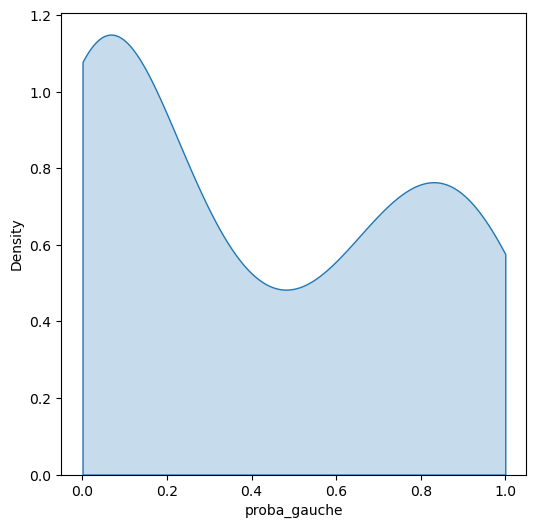

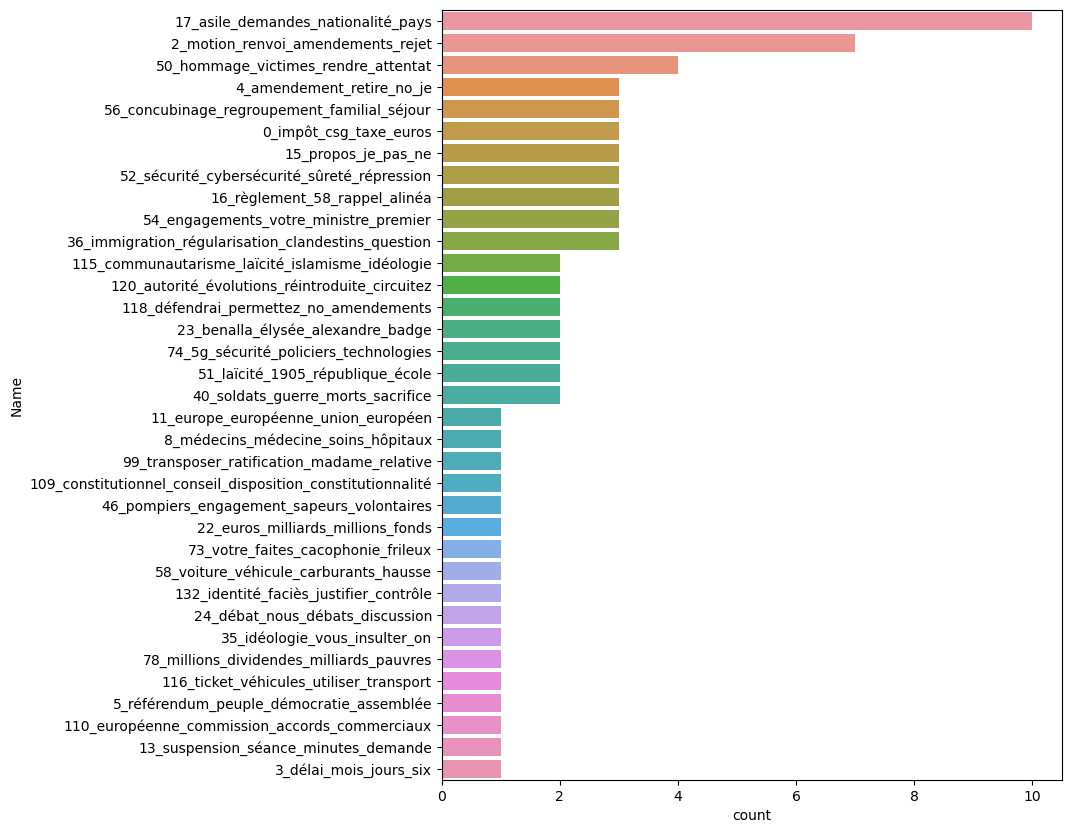

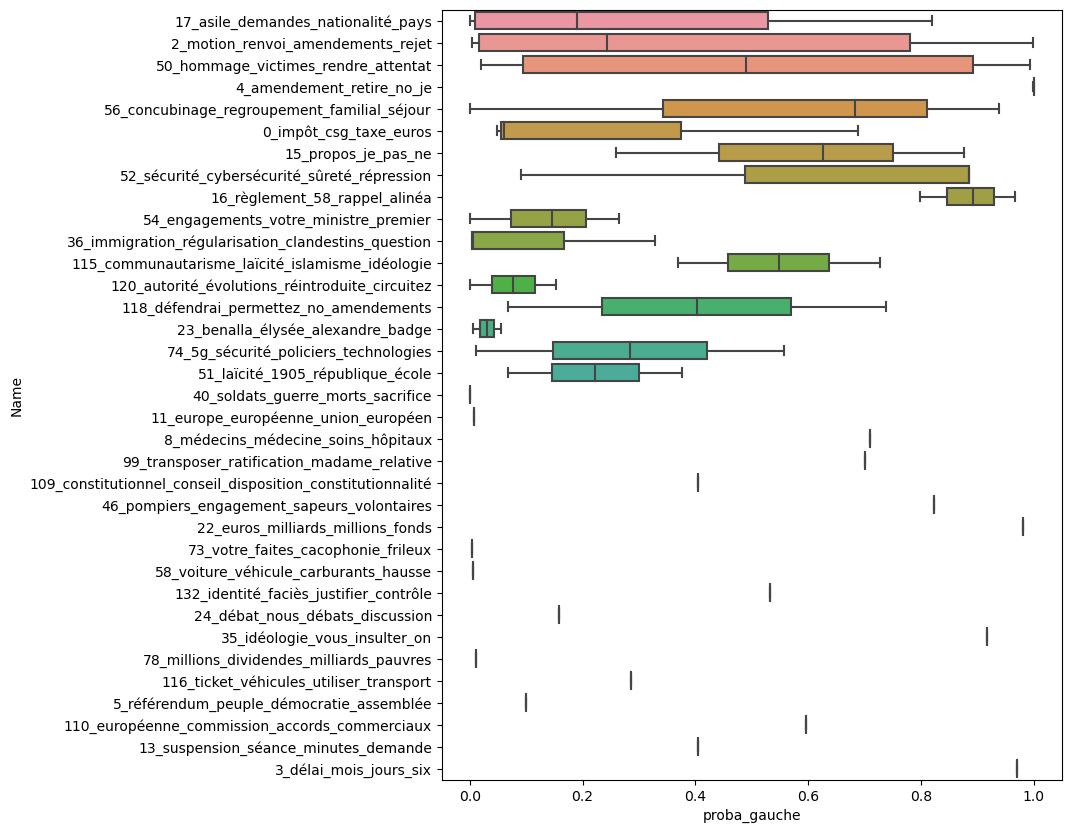

In [126]:
dep = "Éric Ciotti"
dep_name = dep.replace(" ", "_").lower()

sub_df = get_prob_for_deputy(dep)
sub_df.to_csv(RESULT_DIR / f"df_{dep_name}.csv", index=False)

fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=sub_df, x="proba_gauche", shade=True, label="Proba de Gauche", cut=0)
fig.savefig(RESULT_DIR / f"probs_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.countplot(data=sub_df, y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"topics_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(data=sub_df, x="proba_gauche", y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"boxplots_{dep_name}.png")

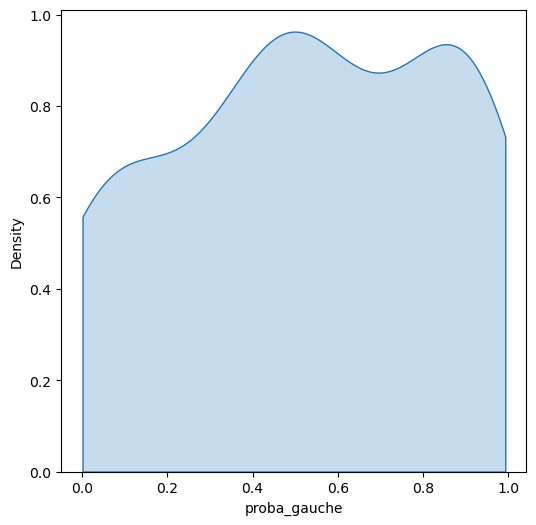

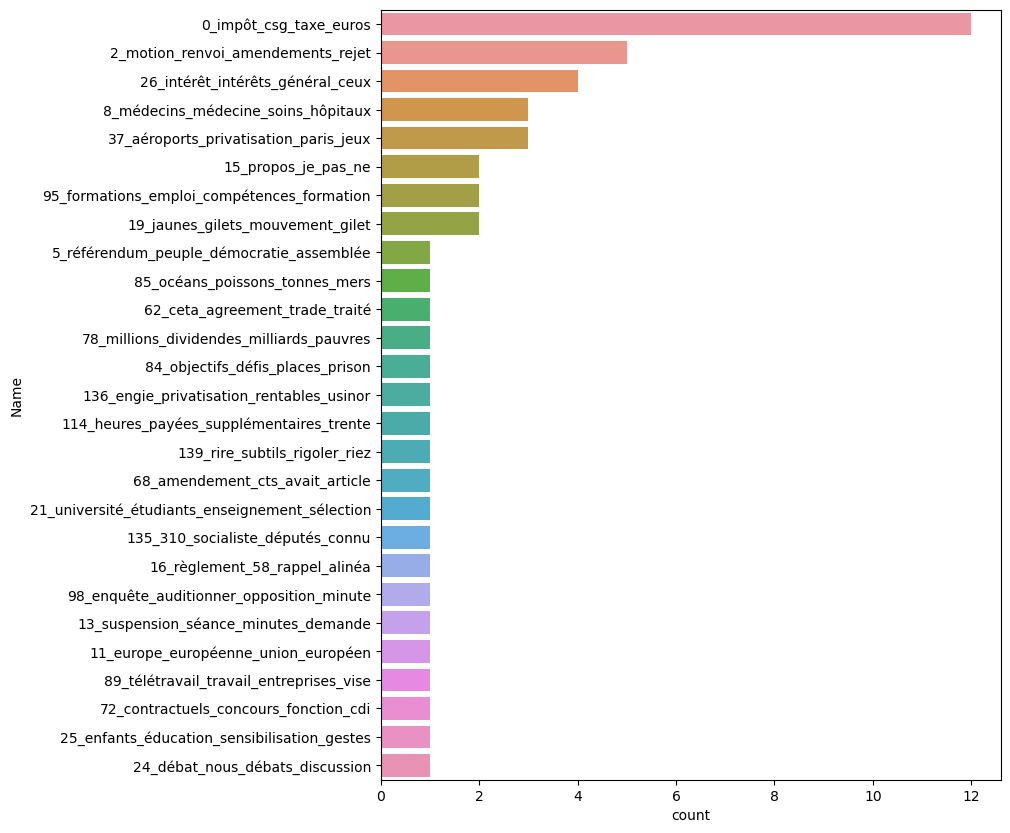

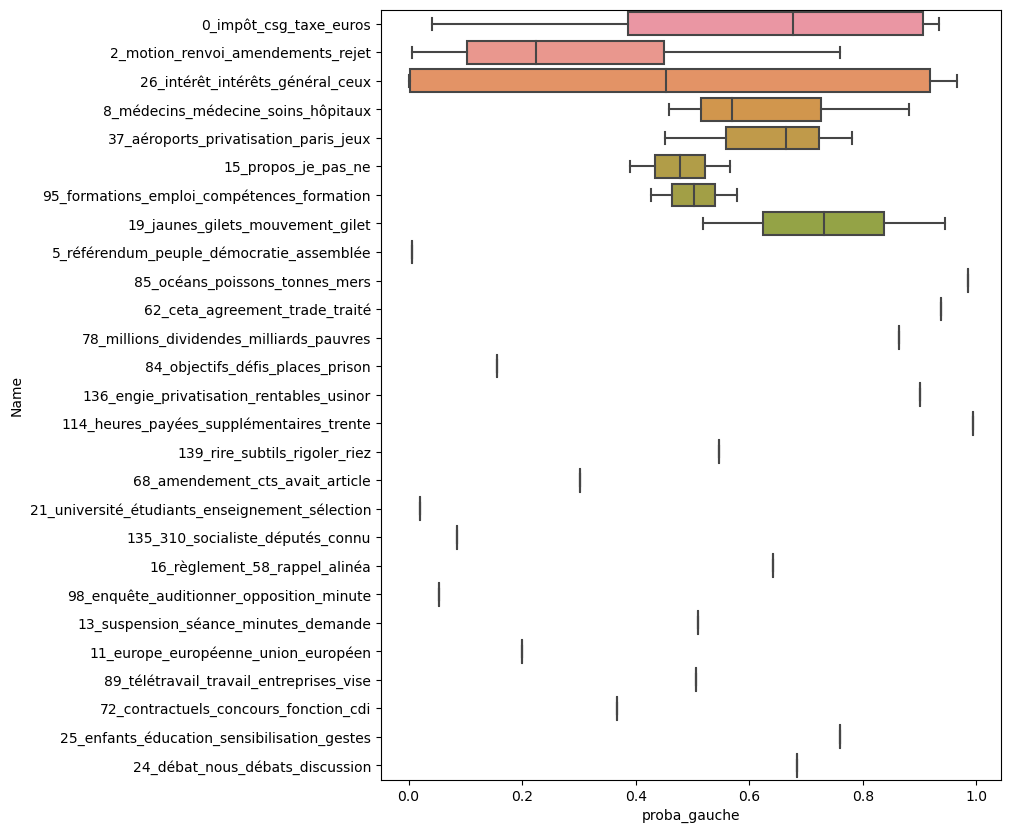

In [127]:
dep = "Adrien Quatennens"
dep_name = dep.replace(" ", "_").lower()

sub_df = get_prob_for_deputy(dep)


fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=sub_df, x="proba_gauche", shade=True, label="Proba de Gauche", cut=0)
fig.savefig(RESULT_DIR / f"probs_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.countplot(data=sub_df, y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"topics_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(data=sub_df, x="proba_gauche", y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"boxplots_{dep_name}.png")

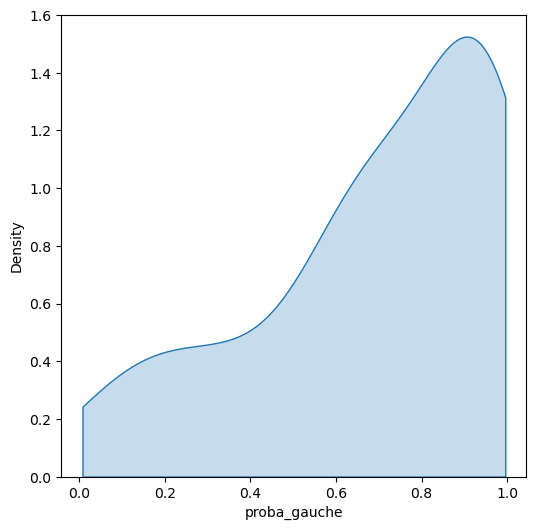

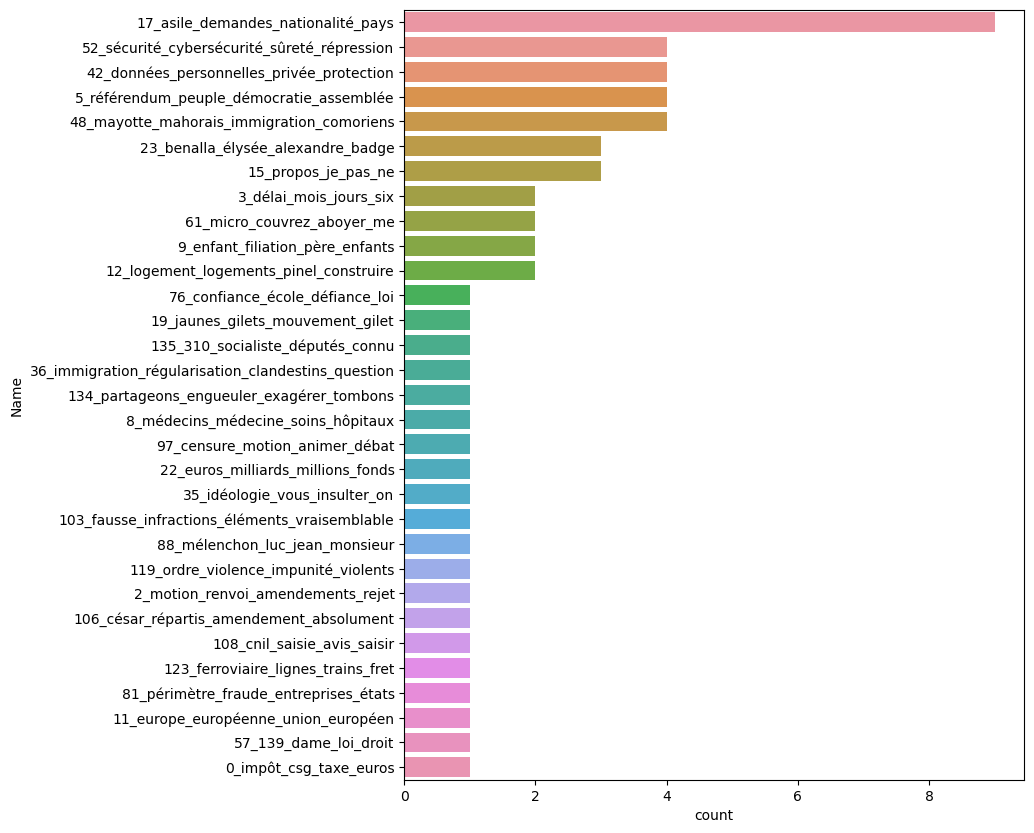

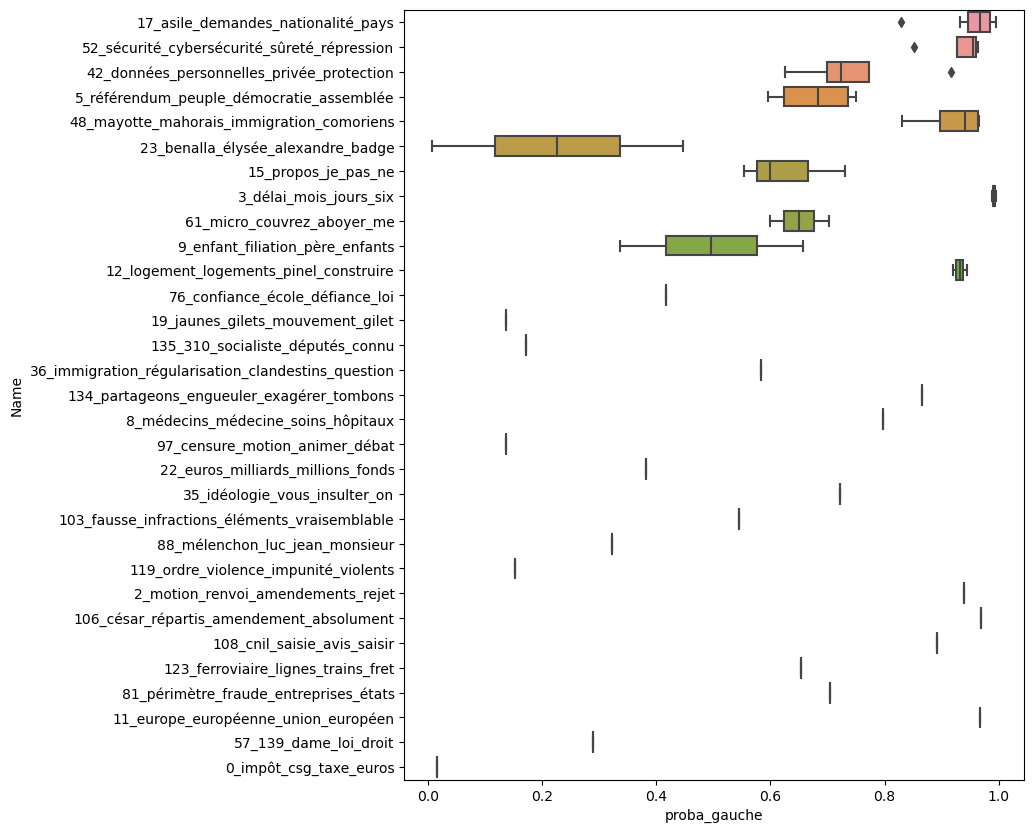

In [128]:
dep = "Marine Le Pen"
dep_name = dep.replace(" ", "_").lower()

sub_df = get_prob_for_deputy(dep)
sub_df.to_csv(RESULT_DIR / f"df_{dep_name}.csv", index=False)


fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=sub_df, x="proba_gauche", shade=True, label="Proba de Gauche", cut=0)
fig.savefig(RESULT_DIR / f"probs_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.countplot(data=sub_df, y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"topics_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(data=sub_df, x="proba_gauche", y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"boxplots_{dep_name}.png")

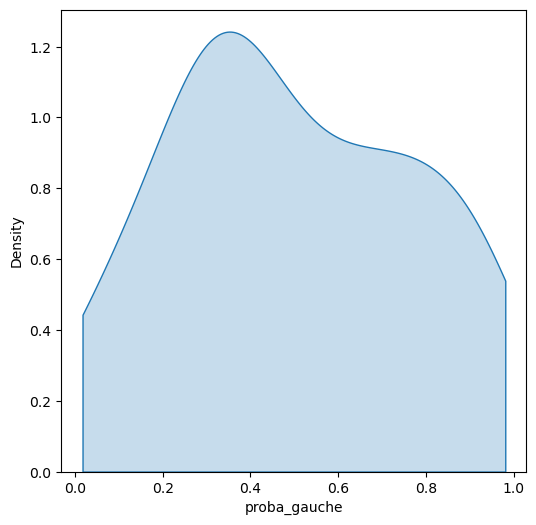

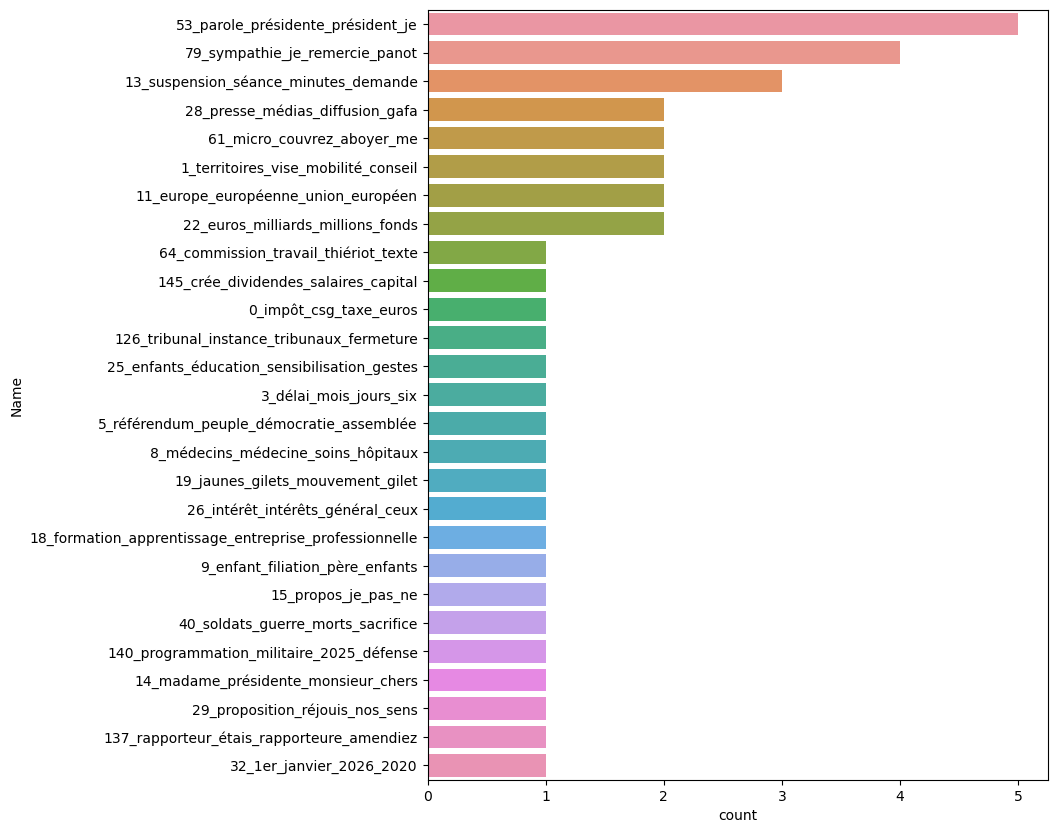

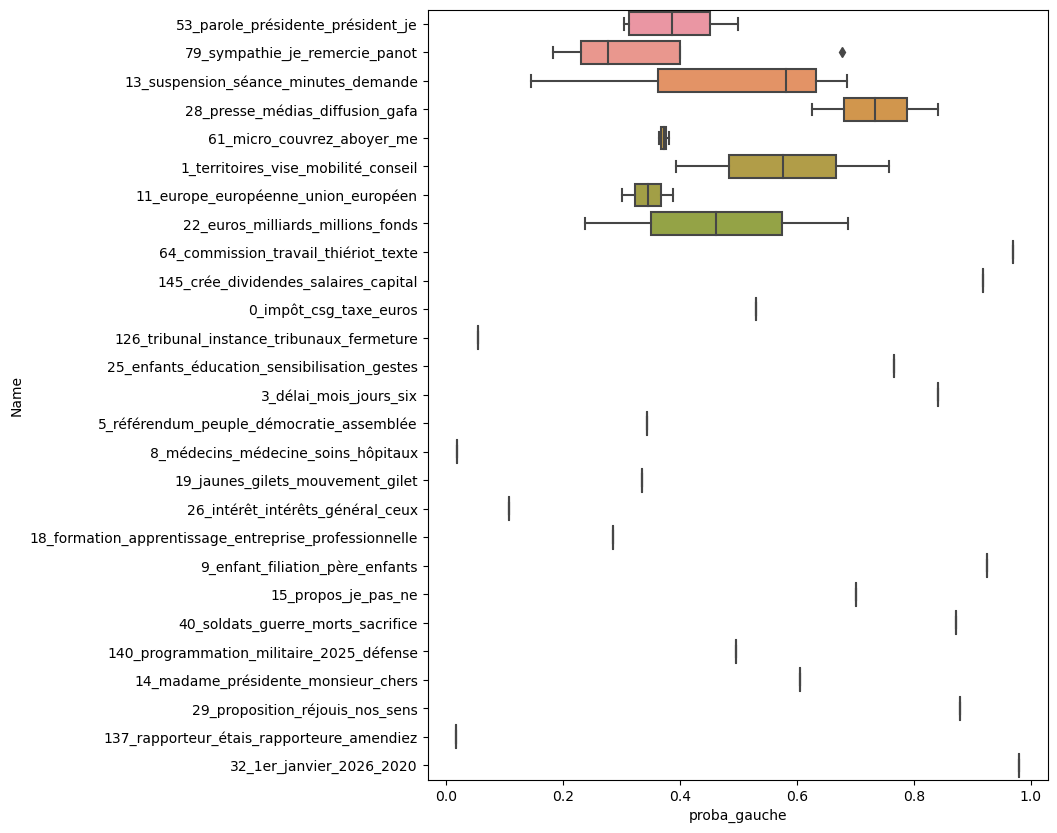

In [130]:
dep = "Jean Lassalle"
dep_name = dep.replace(" ", "_").lower()

sub_df = get_prob_for_deputy(dep)
sub_df.to_csv(RESULT_DIR / f"df_{dep_name}.csv", index=False)


fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=sub_df, x="proba_gauche", shade=True, label="Proba de Gauche", cut=0)
fig.savefig(RESULT_DIR / f"probs_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.countplot(data=sub_df, y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"topics_{dep_name}.png")

fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(data=sub_df, x="proba_gauche", y="Name", order=sub_df["Name"].value_counts().index)
fig.savefig(RESULT_DIR / f"boxplots_{dep_name}.png")

In [ ]:
topic_model.get_topic(32), topic_model.get_representative_docs()[32]

([('voter', 0.058836506641460125),
  ('voté', 0.04345341155070221),
  ('vote', 0.04043550656880997),
  ('référendum', 0.03190168899345815),
  ('votée', 0.03085901351204949),
  ('partielles', 0.015615064621541497),
  ('votez', 0.015188404602185025),
  ('abstention', 0.013220348037831049),
  ('avons', 0.012307311462921602),
  ('fallait', 0.010637681712700109)],
 ['Attendez quand même que nous votions !',
  'Il y a juste à voter ce texte !',
  "Il ne l'est pas, mais nous sommes obligés de voter dessus !"])

In [ ]:
topic_model.get_topic(13), topic_model.get_representative_docs()[13]

([('socialiste', 0.09664525514953672),
  ('socialistes', 0.08120721263312758),
  ('gauche', 0.06957814740884048),
  ('ps', 0.053835289198021115),
  ('droite', 0.04747320540808662),
  ('époque', 0.0364934194114318),
  ('étiez', 0.035260295778863394),
  ('ancien', 0.025986827414760633),
  ('parti', 0.018871246098008367),
  ('était', 0.01797865430101777)],
 ["L'amicale des anciens du Mouvement des jeunes socialistes !",
  "C'est un ancien socialiste qui vous parle !",
  "On n'a jamais dit que vous étiez trop à droite !"])

In [ ]:
topic_model.get_topic(22), topic_model.get_representative_docs()[22]

([('ministre', 0.047100950547926526),
  ('madame', 0.029920643776806827),
  ('monsieur', 0.02373303359193897),
  ('merci', 0.014350496481126693),
  ('remercie', 0.012306366780777796),
  ('faites', 0.01181213259750535),
  ('élu', 0.01124345951972022),
  ('comptons', 0.011031257493999132),
  ('êtes', 0.009320140533890022),
  ('armor', 0.008468448493831044)],
 ['Vous nous avez manqué, madame la ministre !',
  'Nous vous attendons, madame la ministre !',
  'Vous pourriez arranger cela, monsieur le ministre !'])

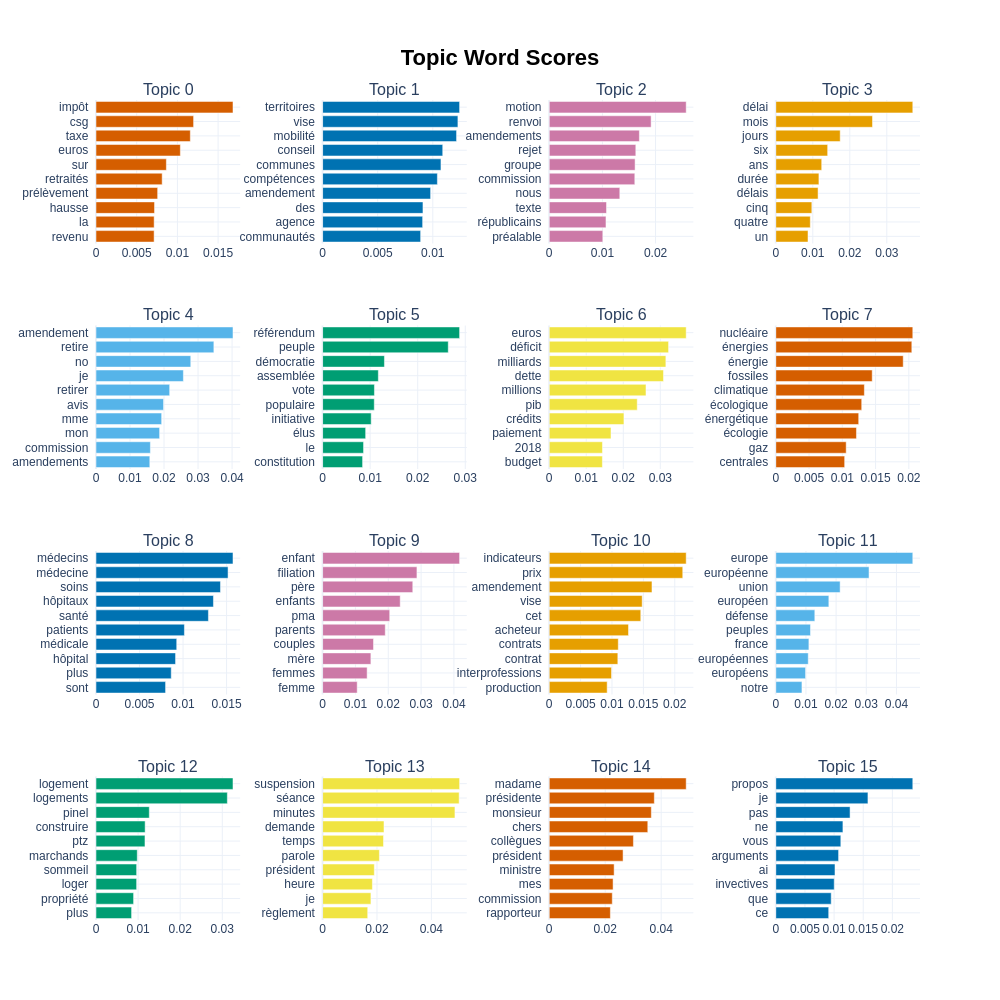

In [141]:
words_fig = topic_model.visualize_barchart(top_n_topics=16, n_words=10)
words_fig.write_html(RESULT_DIR / "topic_modelling_words.html", include_plotlyjs="cdn")
words_fig.write_image(RESULT_DIR / "topic_modelling_words.png")
words_fig.show(renderer="png")

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
topic_model.visualize_term_rank()